# Charge, Polarity, and Isoelectric point

In [2]:
import re
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
dfs = []
for proteome_file in glob.glob('../data/alphafold/v2/AA_scores/*.csv'):
    proteome = re.search(r"/([A-Z0-9]+).csv", proteome_file).group(1)
    proteome_df = pd.read_csv(proteome_file, index_col=0)
    proteome_df['proteome'] = proteome
    dfs.append(proteome_df)
df = pd.concat(dfs)

In [16]:
df.describe()

,seq_len,domain_count,min_plddt,mean_plddt,median_plddt,ratio_bad_plddt,iupred_auc,iupred_plddt_spearman,repeat_6mers_2000,non_repeat_6mers_2000,aa_distr_js,freq_pos_charge,freq_neg_charge,freq_polar,freq_non_polar,IEP,suboptim_compress
count,1.087298e+06,545555.00000,1.087298e+06,1.087298e+06,1.087298e+06,1.087298e+06,1.075450e+06,513491.000000,1.056365e+06,1.056365e+06,1.072382e+06,1.072382e+06,1.072382e+06,1.072382e+06,1.072382e+06,1.072382e+06,207722.000000
mean,4.064420e+02,1.11808,3.911778e+01,8.141461e+01,8.507000e+01,2.450463e-01,6.128500e+01,-0.311983,4.908758e-01,9.778296e-01,1.582429e-01,1.408789e-01,1.159461e-01,5.110148e-01,2.321597e-01,7.157321e+00,0.133778
std,6.549869e+02,12.27124,1.504080e+01,1.434268e+01,1.668829e+01,2.702486e-01,1.202969e+02,0.317159,4.024742e+00,4.935259e+00,6.244004e-02,4.279119e-02,3.881219e-02,7.133074e-02,5.411152e-02,1.922474e+00,0.101513
min,1.600000e+01,0.00000,1.390000e+00,2.307730e+01,2.217000e+01,0.000000e+00,0.000000e+00,-0.987435,0.000000e+00,0.000000e+00,3.044343e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.050000e+00,0.000000
25%,1.790000e+02,0.00000,2.785000e+01,7.301250e+01,8.187000e+01,3.530000e-02,2.271000e-01,-0.564031,0.000000e+00,0.000000e+00,1.139000e-01,1.172000e-01,9.420000e-02,4.683000e-01,1.977000e-01,5.506800e+00,0.054900
50%,3.130000e+02,0.00000,3.519000e+01,8.596510e+01,9.246000e+01,1.362000e-01,5.527000e-01,-0.345583,0.000000e+00,0.000000e+00,1.457000e-01,1.369000e-01,1.173000e-01,5.090000e-01,2.286000e-01,6.547900e+00,0.112800
75%,4.900000e+02,1.00000,4.652000e+01,9.291620e+01,9.639500e+01,3.718000e-01,7.707628e+01,-0.103957,0.000000e+00,1.000000e+00,1.881000e-01,1.584000e-01,1.380000e-01,5.510000e-01,2.615000e-01,8.933500e+00,0.194200
max,3.220000e+04,285.00000,9.738000e+01,9.875400e+01,9.887000e+01,1.000000e+00,2.730700e+03,0.918797,3.860000e+02,6.730000e+02,7.746000e-01,9.524000e-01,8.889000e-01,1.000000e+00,9.875000e-01,1.200000e+01,0.680400


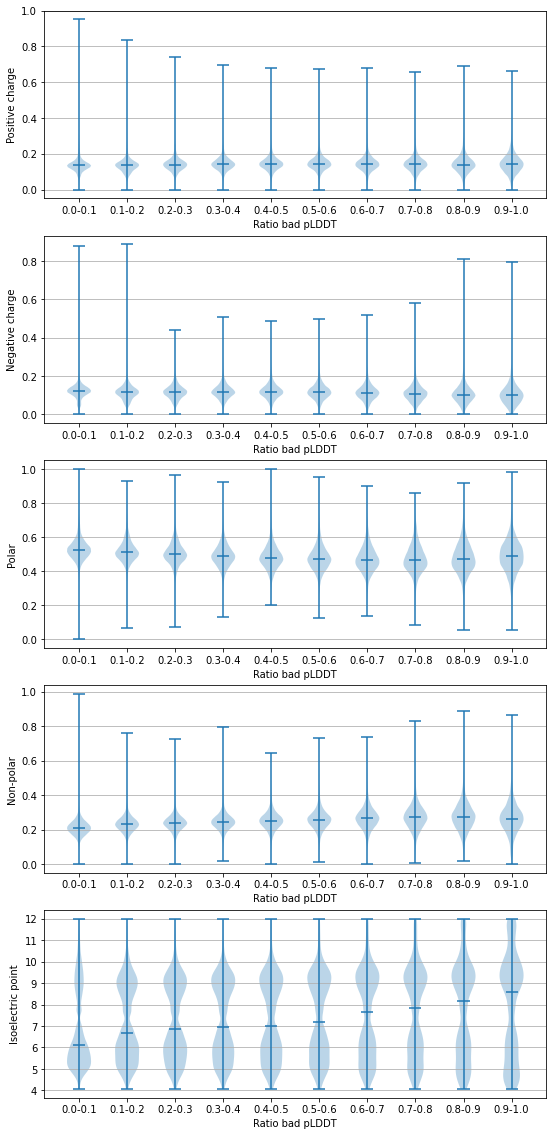

In [17]:
%matplotlib inline
fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(nrows=5, figsize=(9, 20))

def violin_plot(ax, prop, title, bucket_step_size=0.1, decimals=1):
    xprop = 'ratio_bad_plddt'
    df_without_na = df.dropna(subset=[prop])
    buckets_indices = np.arange(np.floor(df_without_na[xprop].min()), df_without_na[xprop].max(), bucket_step_size)
    buckets = [df_without_na[df_without_na[xprop].between(i, i + bucket_step_size, inclusive='left')] for i in buckets_indices]
    labels = [f'{np.round(i, decimals=decimals)}-{np.round(i + bucket_step_size, decimals=decimals)}' for i in buckets_indices]
    ax.violinplot(dataset = [bucket[prop].values for bucket in buckets], showmedians=True)
    ax.yaxis.grid(True)
    ax.set_xlabel('Ratio bad pLDDT')
    ax.set_ylabel(title)
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)

violin_plot(ax1, 'freq_pos_charge', 'Positive charge')
violin_plot(ax2, 'freq_neg_charge', 'Negative charge')
violin_plot(ax3, 'freq_polar', 'Polar')
violin_plot(ax4, 'freq_non_polar', 'Non-polar')
violin_plot(ax5, 'IEP', 'Isoelectric point')

plt.show()

In [18]:
from scipy.stats import spearmanr

df_with_IEP = df.dropna(subset=['IEP'])
rho, p = spearmanr(df_with_IEP['ratio_bad_plddt'], df_with_IEP['IEP'])
print(f'Spearman rank correlation (IEP): {"{0:.4f}".format(rho)}')

Spearman rank correlation (IEP): 0.1550


In [21]:
from sklearn.feature_selection import mutual_info_regression

mutual_info = mutual_info_regression(df_with_IEP['IEP'].values.reshape(-1, 1), df_with_IEP['ratio_bad_plddt'])[0]
print(f'Mutual information (IEP): {"{0:.4f}".format(mutual_info)}')

Mutual information (IEP): 0.5131


In [22]:
df_no_na = df_with_IEP.dropna(subset=['IEP', 'aa_distr_js', 'repeat_6mers_2000', 'iupred_auc'])
mutual_info_regression(df_no_na[['IEP', 'aa_distr_js', 'repeat_6mers_2000', 'iupred_auc']], df_no_na['ratio_bad_plddt'])

array([0.50388121, 0.31085053, 0.06355207, 0.41912803])